In [1]:
import json
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
images_path = '../../halte-data/coco/val2017/'
segments_path = '../../halte-data/coco/annotations/instances_val2017.json'

In [4]:
with open(segments_path, 'r') as f:
    segments = json.load(f)

In [5]:
segments.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [6]:
images_df = pd.DataFrame.from_dict(segments['images'])
categories_df = pd.DataFrame.from_dict(segments['categories'])
annotations_df = pd.DataFrame.from_dict(segments['annotations'])

In [7]:
images_df.head()

,coco_url,date_captured,file_name,flickr_url,height,id,license,width
0,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640
1,http://images.cocodataset.org/val2017/00000003...,2013-11-14 20:55:31,000000037777.jpg,http://farm9.staticflickr.com/8429/7839199426_...,230,37777,1,352
2,http://images.cocodataset.org/val2017/00000025...,2013-11-14 22:32:02,000000252219.jpg,http://farm4.staticflickr.com/3446/3232237447_...,428,252219,4,640
3,http://images.cocodataset.org/val2017/00000008...,2013-11-14 23:11:37,000000087038.jpg,http://farm8.staticflickr.com/7355/8825114508_...,480,87038,1,640
4,http://images.cocodataset.org/val2017/00000017...,2013-11-14 23:16:55,000000174482.jpg,http://farm8.staticflickr.com/7020/6478877255_...,388,174482,6,640


In [8]:
categories_df.head()

,id,name,supercategory
0,1,person,person
1,2,bicycle,vehicle
2,3,car,vehicle
3,4,motorcycle,vehicle
4,5,airplane,vehicle


In [9]:
categories_df[categories_df['supercategory']=='person']

,id,name,supercategory
0,1,person,person


So the only category that matters in this case is `id==1`

In [10]:
annotations_df.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,702.10575,"[473.07, 395.93, 38.65, 28.67]",18,1768,289343,0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416...."
1,27718.47630,"[272.1, 200.23, 151.97, 279.77]",18,1773,61471,0,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427...."
2,78969.31690,"[124.71, 196.18, 372.85, 356.81]",18,2551,472375,0,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347...."
3,108316.66515,"[112.71, 154.82, 367.29, 479.35]",18,3186,520301,0,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6..."
4,75864.53530,"[200.61, 89.65, 400.22, 251.02]",18,3419,579321,0,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336...."


In [11]:
person_annotations_df = annotations_df[annotations_df['category_id']==1]
person_annotations_df.reset_index(inplace=True, drop=True)
person_annotations_df.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,47803.27955,"[73.35, 206.02, 300.58, 372.5]",1,183126,425226,0,"[[125.12, 539.69, 140.94, 522.43, 100.67, 496...."
1,1394.74310,"[491.91, 183.51, 34.85, 73.4]",1,183302,440475,0,"[[492.38, 238.33, 491.91, 234.15, 494.47, 227...."
2,938.33980,"[36.32, 0.59, 38.56, 53.86]",1,183830,266400,0,"[[41.21, 3.04, 43.66, 10.38, 52.23, 11.61, 57...."
3,68822.32895,"[276.35, 9.6, 244.69, 400.13]",1,184249,69213,0,"[[285.95, 274.43, 297.46, 145.85, 364.63, 121...."
4,485.51655,"[97.1, 185.73, 28.66, 27.72]",1,184327,555050,0,"[[105.92, 200.85, 104.35, 192.34, 105.92, 185...."


In [12]:
print('Kept {} annotations of people, out of a total of {} object annotations'.format(len(person_annotations_df), len(annotations_df)))

Kept 11004 annotations of people, out of a total of 36781 object annotations


In [13]:
person_images_df = images_df[images_df['id'].isin(person_annotations_df['image_id'].unique())]
print('Out of {} images, {} contain people'.format(len(images_df), len(person_images_df)))

Out of 5000 images, 2693 contain people


In [14]:
def draw_box(original_img, box):
    p1 = (int(box[0]), int(box[1]))
    p2 = (int(box[0] + box[2]), int(box[1] + box[3]))
    img_w_box = cv2.rectangle(original_img, p1, p2, (0,0,255), 2)
    return img_w_box

In [15]:
def box_all_people(img_info):
    filename = img_info['file_name'].values[0]
    image = cv2.imread(images_path+filename)
    boxes = person_annotations_df[person_annotations_df['image_id']==img_info['id'].values[0]]
    for bbox in boxes['bbox'].values:
        image = draw_box(image, bbox)
    return image

In [16]:
def convert_segmentation_to_points(seg):
    p_list = []
    for i in range(0, len(seg), 2):
        p_list.append( [int(seg[i]), int(seg[i+1])] )
    return np.array([p_list])

In [17]:
def draw_polygon(original_img, pts):
    img_w_poly = cv2.polylines(original_img, [pts], True, (0,0,255), 2)
    return img_w_poly

In [18]:
def segment_all_people(img_info):
    filename = img_info['file_name'].values[0]
    image = cv2.imread(images_path+filename)
    objects = person_annotations_df[person_annotations_df['image_id']==img_info['id'].values[0]]
    for annotation in objects['segmentation'].values:
        for segment in annotation:
            p_list = convert_segmentation_to_points(segment)
            image = draw_polygon(image, p_list)
    return image

In [19]:
def display_image(img, title='None'):
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

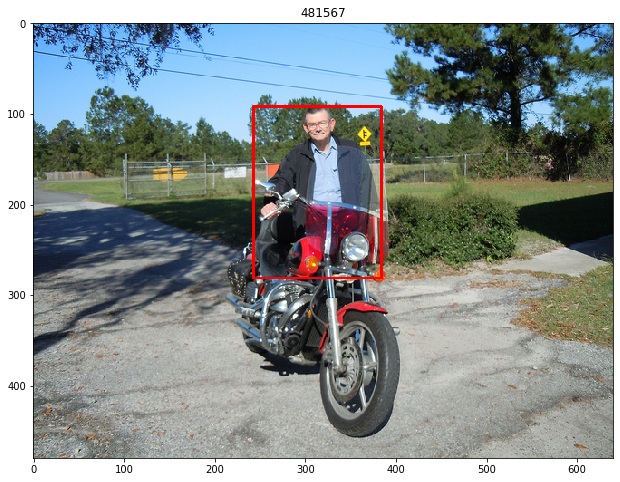

In [24]:
sample_img = person_images_df.sample(1)
# sample_img = person_images_df[person_images_df['id']==481567]
img = box_all_people(sample_img)

display_image(img, sample_img['id'].values[0])

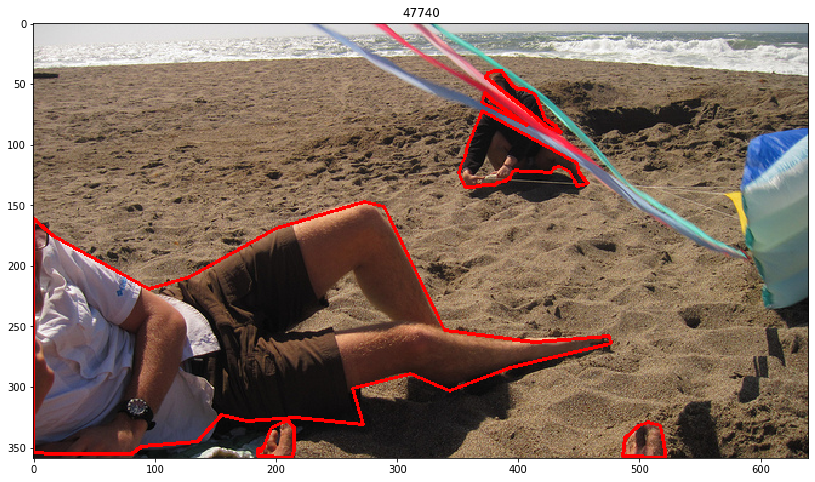

In [30]:
sample_img = person_images_df.sample(1)
img = segment_all_people(sample_img)

display_image(img, sample_img['id'].values[0])